# Description
---

The purpose of this notebook is to -
- discover patterns in web data 
- aggregate events level data to the required level with a prediction 'goal' in mind
- clean the aggregated data
- understand the relationship between predictors and goal 

The notebook has been optimized with web-based data in mind.

**Part I: Data Discovery**<br>
&emsp;&emsp;&emsp;We will start with Analytics Events level data and view trends/data snapshots using Query Service. Then we will aggregate the data at the profile/visitor level with a 'goal' in mind to do exploratory data analysis.<br><br>
**Part II: Exploratory Data Analysis**<br>
&emsp;&emsp;&emsp;We will do descriptive analysis on aggregated data. We will also use python libraries to create visualizations such as histograms, scatter plots, boxplots, correlation matrix to derive actionable insights. Finally we would know which features are most likely to be helpful in predicting a 'goal'.

**Note:** This notebook utilizes midvalues of Analytics Experience Events data, namely:
  * **midvalues:**  "reflects the data as it's used in Analysis Workspace"


### Contents:
### [Part I: Data Discovery](#Part1)
#### [Configuration](#config)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Explore the dataset for dates available](#data1)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Configurable parameters : Dates for dataset discovery](#data2)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Dataset Discovery](#data3)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Query 1: Hourly Activity Count for a Given Day](#q2)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Query 2: Top 10 Viewed Pages For a Given Day](#q4)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Query 3: Top Ten Cities by User Activity](#q6)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Query 4: Top Ten Viewed Products](#q7)
### [Part II: Exploratory Data Analysis](#Part2)
#### [Configuration](#config2)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Data Aggregation and Goal Creation](#q11)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Merge Features with Goal and visualize data](#q12)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Detect missing values and outliers](#q13)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Univariate Anlaysis](#q14)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Remove columns that have a single distinct value](#q15)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Correct missing values](#q16)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Bivariate Analysis](#q17)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Important features](#q18)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Insights](#q19)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Optional steps : Treat outliers](#q20)

<a id="Part1"></a>

#### <font color='purple'>**We will need to configure the dates and other parameters for section 1 and 2 to work, please update cells as suggested**</font>

# Section 1 : Data discovery
---

# Configuration of libraries

In [1]:
!pip install colorama
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import math
import re
import seaborn as sns
from datetime import datetime
import colorama
from colorama import Fore, Style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

INFO:matplotlib.font_manager:generated new fontManager


# Query Service Configuration

In [2]:
qs_connect()

<a id="config"></a>

# Configurable Parameters : Dataset

We define the parameters for the notebook in the following cell. 

#### Define the data table of interest, we can use any midvalues dataset here <br> <br> <font color='purple'>**User input required in the below code**</font>

In [3]:
target_table = "luma_web_data"
target_table_id = "6064fe1a708b001948bc1dbb"

<a id="data1"></a>

# Explore the dataset for dates available

View the date range covered in the table, here we explore the month and year wise:
<br>
-- Number of days for which data is available
<br>
-- First date for which data is available
<br>
-- Last date for which data is available

In [4]:
%%read_sql -c QS_CONNECTION
SELECT distinct Year(timestamp) as Year, Month(timestamp) as Month, count(distinct DAY(timestamp)) as Count_days, min(DAY(timestamp)) as First_date, max(DAY(timestamp)) as Last_date, count(timestamp) as Count_hits
from {target_table}
group by Month(timestamp), Year(timestamp)
order by Year, Month;

Query started at 11:04:59 AM UTC; Query executed in 0.89 m

Year  Month  Count_days  First_date  Last_date  Count_hits
0  2020  6      1           30          30         264       
1  2020  7      31          1           31         107594    
2  2020  8      31          1           31         106645    
3  2020  9      30          1           30         102258    
4  2020  10     31          1           31         106183    
5  2020  11     30          1           30         105209    
6  2020  12     31          1           31         106394    
7  2021  1      29          1           29         98718

#### Now that we know the date range for which data is available, let us select the date range that we are interested in for furthur analysis

<a id="data2"></a>

# Configurable parameters : Dates for dataset discovery
#### <font color='purple'>**User input required in the below code**</font>

In [5]:
target_year = "2021" ## date feature for the data we want to view
target_month = "01" ## date feature for the data we want to view
target_day = "(01,02,03)" ## date feature for the data we want to view

The queries used throughout the first section of this notebook will be based on data from 9/1/2019 to 9/3/2019.
<br>
Please note : this is only for data discovery, we will update the dates for suitable ranges for exploratory data analysis.

<a id="data3"></a>

# Dataset discovery

Read the first few rows of the data to view them

In [6]:
from platform_sdk.dataset_reader import DatasetReader
from datetime import date
dataset_reader = DatasetReader(PLATFORM_SDK_CLIENT_CONTEXT, dataset_id=target_table_id)
# If you do not see any data or would like to expand the default date range, change the following query
Table = dataset_reader.limit(500000).read()

INFO:PlatformSDKPython:dataset_reader: seconds taken to get dataset details from catalog and make PQS connection: 1.33
INFO:PlatformSDKPython:dataset_id: 6064fe1a708b001948bc1dbb, limit: 500000
INFO:PlatformSDKPython:dataset_reader: seconds taken to execute query: 49.5
INFO:PlatformSDKPython:dataset_reader: 500000 rows read. 832.09 MB memory used for this process
INFO:PlatformSDKPython:dataset_reader: seconds taken to format data of dataframe: 9.35


View the number of columns in the dataset

In [7]:
print("\nNumber of columns:",len(Table.columns))


Number of columns: 19


Lets view the first five rows of the dataset

In [8]:
Table.head(5)

_id           channel._id                                   channel._type channel.mediaType commerce.checkouts.value commerce.order.purchaseID commerce.productListAdds.value commerce.productViews.value commerce.purchases.value endUserIDs._experience.emailid.id endUserIDs._experience.emailid.namespace.code          endUserIDs._experience.mcid.id marketing.campaignGroup marketing.campaignName marketing.trackingCode                                                      productListItems                   timestamp web.webPageDetails.name web.webPageDetails.pageViews.value
0  16112410470397883480777432363126  None                  None                                            None              None                     None                      None                           None                        None                     ncressor166@biglobe.ne.jp         email                                         48306837842445078771006515477767747742  None                    None                   None                   []                                                                    2020-09-12T00:00:48.979000  article4                1                                
1  16112410597277575682640107275672  None                  None                                            None              1                        None                      None                           None                        None                     dblowesi36@themeforest.net        email                                         87634207428585285171711216178086518710  None                    None                   None                   [{'SKU': 'LLWP10', 'name': 'Daria Bikram Pant', 'priceTotal': 40.8}]  2020-09-12T00:00:53.056000  checkout                1                                
2  16112410620805867055264771563652  None                  None                                            None              None                     None                      None                           1                           None                     mdignumlcd@elegantthemes.com      email                                         18641812226130866388431115611761044543  None                    None                   None                   [{'name': 'Savvy Shoulder Tote'}]                                     2020-09-12T00:01:25.744000  savvy-shoulder-tote     1                                
3  16112410469305818474060373087810  None                  None                                            None              None                     None                      None                           1                           None                     tvarvell10f@dedecms.com           email                                         56036675462262413347883882784288351710  None                    None                   None                   [{'name': 'Abominable Hoodie'}]                                       2020-09-12T00:02:17.904000  abominable-hoodie       1                                
4  16112410625128636773831807586362  up-to-50-off-on-gear  https://ns.adobe.com/xdm/channel-types/display  paid              None                     None                      None                           None                        None                     nharnerlxl@salon.com              email                                         33140700123837481488036726326626717728  paid                    Up To 50% Off On Gear  up-to-50-off-on-gear   []                                                                    2020-09-12T00:04:07.212000  up-to-50-off-on-gear    1

Let us list down the column names and the data types for each of the columns contained in the target table

In [9]:
ColumnNames_Types = pd.DataFrame(Table.dtypes)
ColumnNames_Types = ColumnNames_Types.reset_index()
ColumnNames_Types.columns = ["Column_Name", "Data_Type"]
ColumnNames_Types

Column_Name Data_Type
0   _id                                            object  
1   channel._id                                    object  
2   channel._type                                  object  
3   channel.mediaType                              object  
4   commerce.checkouts.value                       object  
5   commerce.order.purchaseID                      object  
6   commerce.productListAdds.value                 object  
7   commerce.productViews.value                    object  
8   commerce.purchases.value                       object  
9   endUserIDs._experience.emailid.id              object  
10  endUserIDs._experience.emailid.namespace.code  object  
11  endUserIDs._experience.mcid.id                 object  
12  marketing.campaignGroup                        object  
13  marketing.campaignName                         object  
14  marketing.trackingCode                         object  
15  productListItems                               object  
16  timestamp                                      object  
17  web.webPageDetails.name                        object  
18  web.webPageDetails.pageViews.value             object

<a id="q1"></a>

# Now that we understand what our data contains, let us explore some trends in the data 

The below trends are not exhaustive and are merely the most often looked at features

<a id="q2"></a>

# Query 1: Hourly Activity Count for a Given Day

Our first query will be about analyzing the number of actions, here clicks, throughout the day.

In [10]:
%%read_sql query_2_df -c QS_CONNECTION

SELECT Substring(timestamp, 12, 2)                        AS Hour, 
       Count(endUserIDs._experience.mcid.id) AS Count 
FROM   {target_table}
WHERE  Year(timestamp) = {target_year} 
       AND Month(timestamp) = {target_month}  
       AND Day(timestamp) in {target_day}
GROUP  BY Hour
ORDER  BY Hour;

Query started at 11:09:24 AM UTC; Query executed in 0.60 m

Hour  Count
0   00   353  
1   01   412  
2   02   412  
3   03   433  
4   04   424  
5   05   362  
6   06   430  
7   07   460  
8   08   417  
9   09   416  
10  10   447  
11  11   423  
12  12   420  
13  13   411  
14  14   373  
15  15   398  
16  16   520  
17  17   449  
18  18   359  
19  19   399  
20  20   492  
21  21   421  
22  22   410  
23  23   457

In [11]:
trace = go.Bar(
    x = query_2_df['Hour'],
    y = query_2_df['Count'],
    name = "Activity Count"
)

layout = go.Layout(
    title = 'Activity Count by Hour of Day',
    width = 1200,
    height = 600,
    xaxis = dict(title = 'Hour of Day'),
    yaxis = dict(title = 'Count')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

<a id="q3"></a>

<a id="q4"></a>

# Query 2: Top 10 Viewed Pages For a Given Day

Here we do a query to find out which are the most viewed pages for the given day.

In [15]:
%%read_sql query_4_df -c QS_CONNECTION
SELECT web.webpagedetails.name                 AS Page_Name, 
       Sum(web.webpagedetails.pageviews.value) AS Page_Views 
FROM   {target_table}
WHERE  Year(timestamp) = {target_year}
       AND Month(timestamp) = {target_month}
       AND Day(timestamp) in {target_day}
GROUP  BY web.webpagedetails.name 
ORDER  BY page_views DESC 
LIMIT  10;

Query started at 11:54:06 AM UTC; Query executed in 0.59 m

Page_Name  Page_Views
0  home                 1814.0    
1  blog                 1281.0    
2  men                  674.0     
3  women                641.0     
4  addToCart            544.0     
5  gear                 407.0     
6  november-flash-sale  336.0     
7  free-shipping        245.0     
8  article3             237.0     
9  all-apparel-30-off   234.0

In [16]:
trace = go.Bar(
    x = query_4_df['Page_Name'],
    y = query_4_df['Page_Views'],
    name = "Page Views"
)

layout = go.Layout(
    title = 'Top Ten Viewed Pages For a Given Day',
    width = 1000,
    height = 600,
    xaxis = dict(title = 'Page_Name'),
    yaxis = dict(title = 'Page_Views')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

<a id="q6"></a>

# Query 3: Top Ten Campaigns by user activity

We can also query for the cities in which these activities are originating from.

In [14]:
%%read_sql query_6_df -c QS_CONNECTION
SELECT marketing.campaignName AS campaign_name, 
       Count(timestamp)                                                     AS Count
FROM   {target_table}
WHERE  Year(timestamp) = {target_year}
       AND Month(timestamp) = {target_month}
       AND Day(timestamp) in {target_day}
        AND marketing.campaignName is not null
GROUP  BY campaign_name
ORDER  BY Count DESC
LIMIT  10;

Query started at 02:26:31 PM UTC; Query executed in 0.38 m

campaign_name  Count
0  November Flash Sale                 336  
1  Free Shipping                       245  
2  All Apparel 30% Off                 234  
3  Buy 1 Get 1 Free On All Women Tops  172  
4  All Workout Clothes 20% Off         159  
5  Up To 50% Off On Gear               125  
6  Seasonal Clearance Fall 2020        120  
7  New Styles                          109

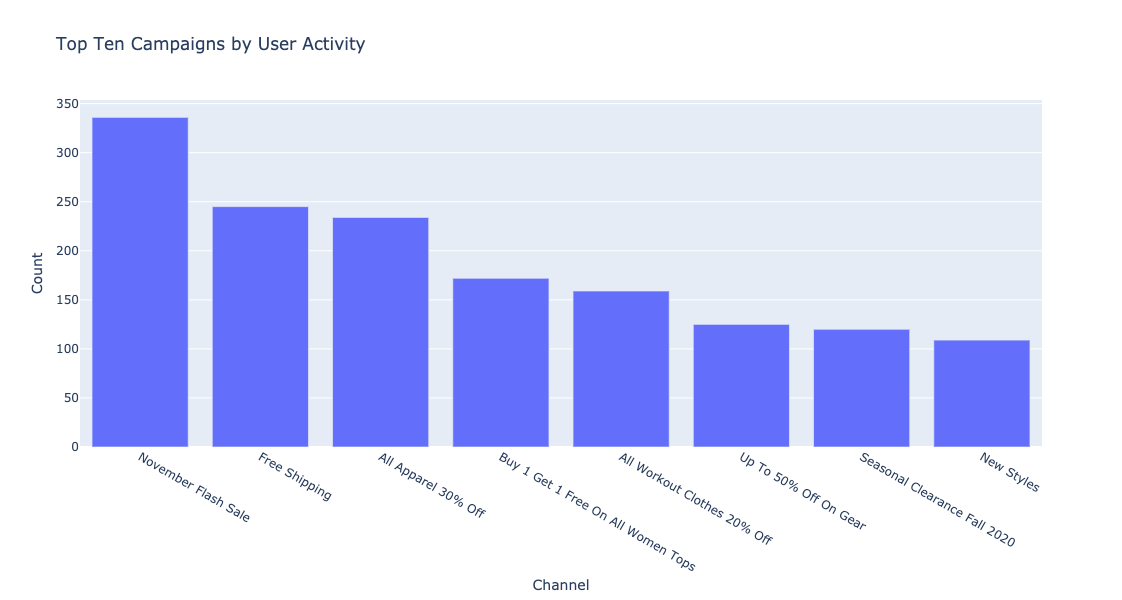

In [15]:
trace = go.Bar(
    x = query_6_df['campaign_name'],
    y = query_6_df['Count'],
    name = "Activity by Channel"
)

layout = go.Layout(
    title = 'Top Ten Campaigns by User Activity',
    width = 1200,
    height = 600,
    xaxis = dict(title = 'Channel'),
    yaxis = dict(title = 'Count')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

<a id="q7"></a>

# Query 4: Top Ten Viewed Products

Here we demonstrate how to use the Explode() function. We can use Explode() to return each product in the productlistitems object to its own row. We then do a nested query to aggregate product views for different SKU's.

In [30]:
%%read_sql query_7_df -c QS_CONNECTION
SELECT productListItems AS Product,
       Sum(commerce.productviews.value) AS Total_Product_Views
FROM  {target_table}
       WHERE  Year(timestamp) = {target_year}
              AND Month(timestamp) = {target_month}
              AND Day(timestamp) in {target_day}
              AND commerce.productviews.value is not null
GROUP BY Product
ORDER BY Total_Product_Views DESC
LIMIT  10;

Query started at 03:10:23 PM UTC; Query executed in 0.40 m

Product  Total_Product_Views
0  (NULL,Montana Wind Jacket,NULL)           30.0               
1  (NULL,Strike Endurance Tee,NULL)          29.0               
2  (NULL,Troy Yoga Short,NULL)               29.0               
3  (NULL,Sinbad Fitness Tank,NULL)           28.0               
4  (NULL,Proteus Fitness Jackshirt,NULL)     28.0               
5  (NULL,Pierce Gym Short,NULL)              27.0               
6  (NULL,Sol Active Short,NULL)              27.0               
7  (NULL,Grayson Crewneck Sweatshirt ,NULL)  26.0               
8  (NULL,Dual Handle Cardio Ball,NULL)       25.0               
9  (NULL,Neve Studio Dance Jacket,NULL)      25.0

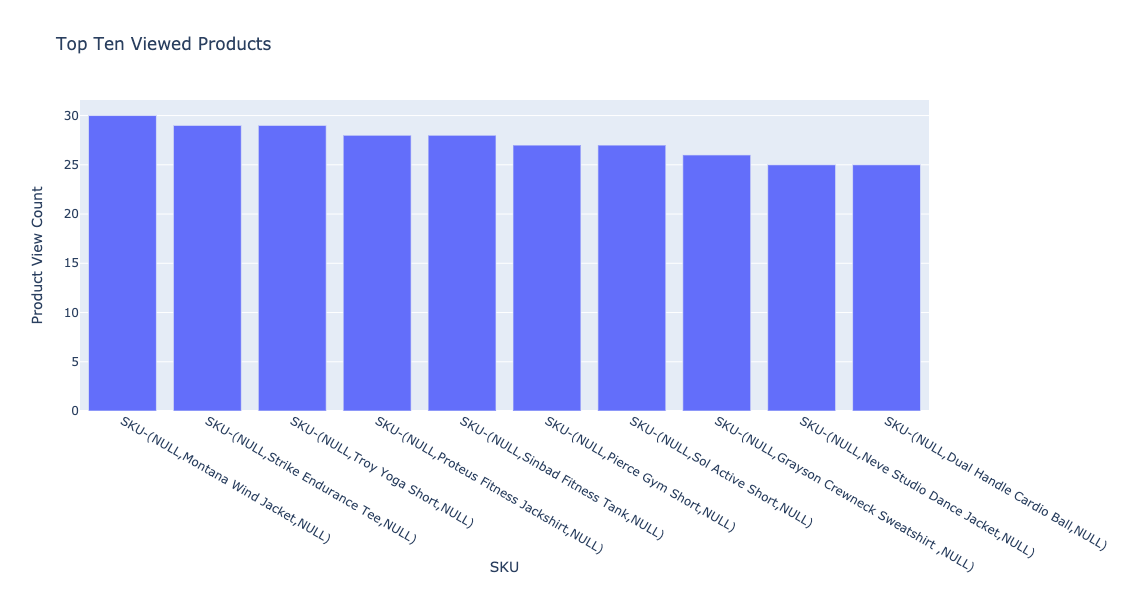

In [22]:
trace = go.Bar(
    x = "SKU-" + query_7_df['Product'],
    y = query_7_df['Total_Product_Views'],
    name = "Product View"
)

layout = go.Layout(
    title = 'Top Ten Viewed Products',
    width = 1200,
    height = 600,
    xaxis = dict(title = 'SKU'),
    yaxis = dict(title = 'Product View Count')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

<a id="Part2"></a>

##### <font color='blue'>**We have the trends from our data, by now we should have a good idea of the features we would want to build for prediction of a goal! In the following section we will define the 'goal' and configure dates for aggregation.**</font>

# Section 2 : Exploratory data analysis
---

In this section we will refine our understanding of the data, build an intuition for compelling questions and ideas that we can use as the basis for your modeling.
<br>
Reference to understand the intuition behind exploratory data analysis : https://machinelearningmastery.com/understand-problem-get-better-results-using-exploratory-data-analysis/

<a id="config2"></a>

# Configurable parameters for prediction of goal (Target Variable)

So far we have explored trends at the event (hit to a website) level data with some aggregations at specified event or city or userID level to see trends for a day.
<br>
For the rest of the notebook, we will endeavour to understand what drives purchase on this website. To this end we will aggregate data at **profile/visitor level** in the analysis window (timeframe in which we study patterns), define **purchase as goal** and apply statistical concepts such as correlation, box plots, scatter plots etc. to compare patterns of activities of **buyers vs non buyers** in the prediction window (timeframe for prediction).

The features that we will create and explore as a part of this notebook are:
<br>
COUNT_UNIQUE_PRODUCTS_PURCHASED : Count of unique products purchased
<br>
COUNT_CHECK_OUTS : Count of check outs
<br>
COUNT_PURCHASES : Count of purchases
<br>
COUNT_INSTANCE_PRODUCTADDS : Counts of product add instances
<br>
NUMBER_VISITS : Number of visits
<br>
COUNT_PAID_SEARCHES : Count of paid searches
<br>
DAYS_SINCE_VISIT : Days since last visit
<br>
TOTAL_ORDER_REVENUE : Order revenue
<br>
DAYS_SINCE_PURCHASE : Days since last purchase
<br>
AVG_GAP_BETWEEN_ORDERS_DAYS : Average gap between purchases in days
<br>

We define the parameters for the prediction variable for exploratory data analysis in the following cell.
#### <font color='purple'>**User input required in the below code**</font>

In [29]:
goal = "`commerce.order.purchaseID`" #### prediction variable
goal_column_type = "numerical" #### choose either "categorical" or "numerical"
prediction_window_day_start = "2020-01-01" #### YYYY-MM-DD
prediction_window_day_end = "2020-09-31" #### YYYY-MM-DD
analysis_period_day_start = "2020-10-01" #### YYYY-MM-DD
analysis_period_day_end = "2021-01-29" #### YYYY-MM-DD
### If goal is categorical goal then select threshold for defining category and creating bins (say 0 is no order placed and 1 is atleast one order placed):
threshold = 1

In [ ]:
%%read_sql -c QS_CONNECTION
SELECT DISTINCT endUserIDs._experience.mcid.id as ID,
count(commerce.`order`.purchaseID) as tg
from {target_table}
WHERE DATE(TIMESTAMP) BETWEEN '{prediction_window_day_start}' AND '{prediction_window_day_end}'
GROUP BY endUserIDs._experience.mcid.id;

<a id="q11"></a>

# Data aggregation for feature and goal creation  

Creation of goal at a profile level

In [38]:
%%read_sql target_df -d -c QS_CONNECTION
SELECT DISTINCT endUserIDs._experience.mcid.id                  AS ID,
       Count({goal})                                            AS GOAL
FROM   {target_table}
WHERE DATE(TIMESTAMP) BETWEEN '{prediction_window_day_start}' AND '{prediction_window_day_end}'
GROUP BY endUserIDs._experience.mcid.id;

Query started at 12:40:54 PM UTC; Query executed in 0.75 m

Aggregation of dataset
<br>
We will need to update the query in aggregation to include any variable other than the ones listed above. At the end of the query "limit" needs to be updated for the number of rows we want to see in the output data. The default here is 50,000 rows.

In [39]:
%%read_sql agg_data -d -c QS_CONNECTION
SELECT y.*,a2.AVG_GAP_BETWEEN_ORDERS_DAYS as AVG_GAP_BETWEEN_ORDERS_DAYS
from
(select a1.*, f.DAYS_SINCE_PURCHASE as DAYS_SINCE_PURCHASE
from
(SELECT DISTINCT a.ID  AS ID,
COUNT(DISTINCT Product_Items) as COUNT_UNIQUE_PRODUCTS_PURCHASED,
COUNT(a.check_out) as COUNT_CHECK_OUTS,
COUNT(a.purchases) as COUNT_PURCHASES, 
COUNT(a.product_list_adds) as COUNT_INSTANCE_PRODUCTADDS,
DATEDIFF('{analysis_period_day_end}', MAX(a.date_a)) as DAYS_SINCE_VISIT
from 
(SELECT endUserIDs._experience.mcid.id  as ID,
commerce.`checkouts`.value as check_out,
commerce.`order`.purchaseID as purchases, 
commerce.`productListAdds`.value as product_list_adds,
DATE(TIMESTAMP) as date_a,
Explode(productlistitems) AS Product_Items
from {target_table}
Where DATE(TIMESTAMP) BETWEEN '{analysis_period_day_start}' AND '{analysis_period_day_end}') as a
group by a.ID) as a1
left join 
(SELECT DISTINCT endUserIDs._experience.mcid.id as ID,
DATEDIFF('{analysis_period_day_end}', max(DATE(TIMESTAMP))) as DAYS_SINCE_PURCHASE
from {target_table}
where DATE(TIMESTAMP) BETWEEN '{analysis_period_day_start}' AND '{analysis_period_day_end}'
and commerce.`order`.purchaseid is not null
GROUP BY endUserIDs._experience.mcid.id) as f
on f.ID = a1.ID
where a1.COUNT_PURCHASES>0) as y
left join
(select ab.ID, avg(DATEDIFF(ab.ORDER_DATES, ab.PriorDate)) as AVG_GAP_BETWEEN_ORDERS_DAYS
from
(SELECT distinct endUserIDs._experience.mcid.id as ID, TO_DATE(DATE(TIMESTAMP)) as ORDER_DATES, 
TO_DATE(LAG(DATE(TIMESTAMP),1) OVER (PARTITION BY endUserIDs._experience.mcid.id ORDER BY DATE(TIMESTAMP))) as PriorDate
FROM {target_table}
where DATE(TIMESTAMP) BETWEEN '{analysis_period_day_start}' AND '{analysis_period_day_end}'
AND commerce.`order`.purchaseid is not null) AS ab
where ab.PriorDate is not null
GROUP BY ab.ID) as a2
on a2.ID = y.ID  
limit 500000;

Query started at 12:56:04 PM UTC; Query executed in 1.43 m

##### <font color='blue'>**We now have aggregated data to start exploration!**</font>

<a id="q12"></a>

# Merge features in aggregated dataset with goal

In [40]:
Data = pd.merge(agg_data,target_df, on='ID',how='left')
Data['GOAL'].fillna(0, inplace=True)

In [41]:
Data.shape

(4420, 9)

In [42]:
Data.head(5)

ID  COUNT_UNIQUE_PRODUCTS_PURCHASED  COUNT_CHECK_OUTS  COUNT_PURCHASES  COUNT_INSTANCE_PRODUCTADDS  DAYS_SINCE_VISIT  DAYS_SINCE_PURCHASE  AVG_GAP_BETWEEN_ORDERS_DAYS  GOAL
0  12413181136427726887260778026783540650  9                                2                 1                3                           13                61                  NaN                           0.0 
1  30806707216085602168513071222615577585  3                                1                 1                1                           39                70                  NaN                           0.0 
2  13506460816116310166315827578565033606  2                                1                 1                1                           89                89                  NaN                           0.0 
3  27578317442514110825665775553670704331  2                                1                 1                1                           34                34                  NaN                           0.0 
4  24626400267470181283706761178645483133  2                                1                 1                1                           1                 1                   NaN                           0.0

In [43]:
print("Count of unique profiles :", (len(Data)))

Count of unique profiles : 4420


<a id="q13"></a>

# Detect missing values and outliers

This process is used to check the sanity of data, identify missing values and outliers and come up with specific strategies for handling them. In this step, we can also sometimes spot corruption in the values that may signal a fault in the data logging process.

In [44]:
Missing = pd.DataFrame(round(Data.isnull().sum()*100/len(Data),2))
Missing.columns =['Percentage_missing_values'] 
Missing['Features'] = Missing.index

In [45]:
trace = go.Bar(
    x = Missing['Features'],
    y = Missing['Percentage_missing_values'],
    name = "Percentage_missing_values")

layout = go.Layout(
    title = 'Missing values',
    width = 1200,
    height = 600,
    xaxis = dict(title = 'Features'),
    yaxis = dict(title = 'Percentage of missing values')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

# Identify outliers in numerical columns. For this we use the inter-quartile range.

Outliers are critical to identify as most parametric statistics, like means, standard deviations, and correlations, and every statistic based on these, are highly sensitive to outliers.  And since the assumptions of common statistical procedures, like linear regression, are also based on these statistics, outliers can really mess up our analysis. 
<br>
To identify outliers we are using inter quartile range. Inter quartile range is the range between the first and the third quartiles (25th and 75th percentiles). Any data point that falls outside of either 1.5 times the IQR below the first – or 1.5 times the IQR above the third – quartile is considered to be “outside” or “far out”.

In [46]:
TARGET = Data.GOAL

Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
Data_numerical.drop(['GOAL'],axis = 1,inplace = True)
Data_numerical1 = Data_numerical

for i in range(0,len(Data_numerical1.columns)):
    Q1 = Data_numerical1.iloc[:,i].quantile(0.25)
    Q3 = Data_numerical1.iloc[:,i].quantile(0.75)
    IQR = Q3 - Q1
    Data_numerical1.iloc[:,i] = np.where(Data_numerical1.iloc[:,i]<(Q1 - 1.5 * IQR),np.nan, np.where(Data_numerical1.iloc[:,i]>(Q3 + 1.5 * IQR),
                                                                                                    np.nan,Data_numerical1.iloc[:,i]))
    
Outlier = pd.DataFrame(round(Data_numerical1.isnull().sum()*100/len(Data),2))
Outlier.columns =['Percentage_outliers'] 
Outlier['Features'] = Outlier.index   

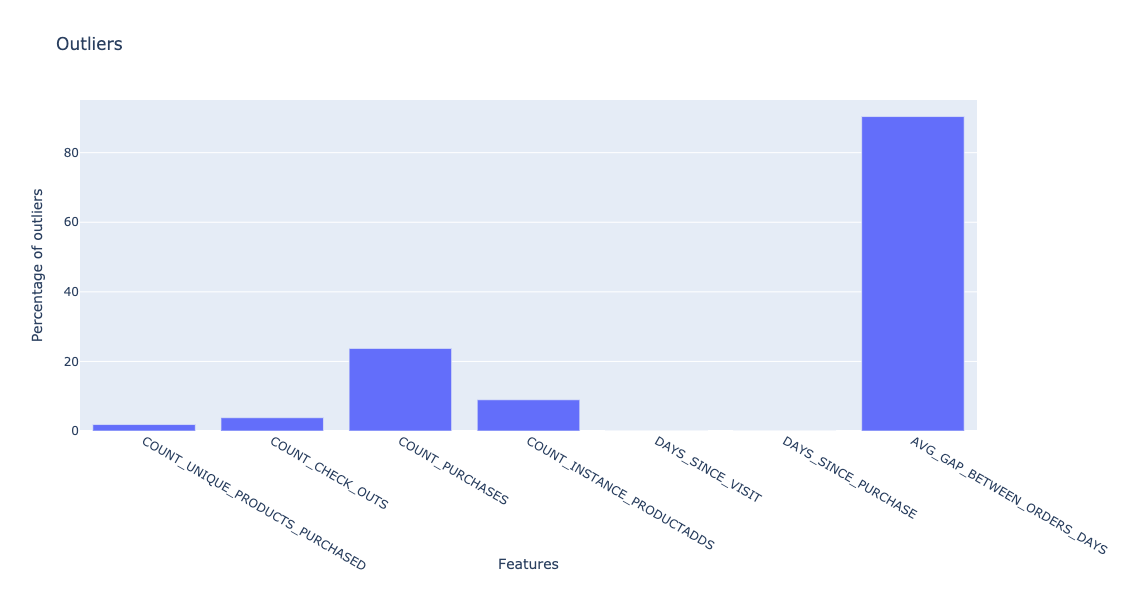

In [47]:
trace = go.Bar(
    x = Outlier['Features'],
    y = Outlier['Percentage_outliers'],
    name = "Percentage_outlier")

layout = go.Layout(
    title = 'Outliers',
    width = 1200,
    height = 600,
    xaxis = dict(title = 'Features'),
    yaxis = dict(title = 'Percentage of outliers')
)

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

##### <font color='blue'>**We are now done with the data health check!**</font>

<a id="q14"></a>

# Univariate Analysis

#### Distribution of the features

In [48]:
Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
distribution = pd.DataFrame([Data_numerical.count(),Data_numerical.mean(),Data_numerical.quantile(0), Data_numerical.quantile(0.01),
                             Data_numerical.quantile(0.05),Data_numerical.quantile(0.25), Data_numerical.quantile(0.5),
                        Data_numerical.quantile(0.75),  Data_numerical.quantile(0.95),Data_numerical.quantile(0.99), Data_numerical.max()])
distribution = distribution.T
distribution.columns = ['Count', 'Mean', 'Min', '1st_perc','5th_perc','25th_perc', '50th_perc','75th_perc','95th_perc','99th_perc','Max']
distribution

Count       Mean  Min  1st_perc  5th_perc  25th_perc  50th_perc  75th_perc  95th_perc  99th_perc    Max
COUNT_UNIQUE_PRODUCTS_PURCHASED  4420.0  5.656561   2.0  2.0       2.0       3.0        5.0        7.0        11.0       15.00      27.0 
COUNT_CHECK_OUTS                 4420.0  1.533710   1.0  1.0       1.0       1.0        1.0        2.0        3.0        5.00       9.0  
COUNT_PURCHASES                  4420.0  1.359502   1.0  1.0       1.0       1.0        1.0        1.0        3.0        5.00       10.0 
COUNT_INSTANCE_PRODUCTADDS       4420.0  1.901357   1.0  1.0       1.0       1.0        2.0        2.0        4.0        5.00       12.0 
DAYS_SINCE_VISIT                 4420.0  39.429412  0.0  0.0       2.0       14.0       32.0       60.0       100.0      115.00     120.0
DAYS_SINCE_PURCHASE              4420.0  57.954072  0.0  0.0       5.0       27.0       57.0       87.0       114.0      119.00     120.0
AVG_GAP_BETWEEN_ORDERS_DAYS      425.0   34.509804  0.0  0.0       0.0       9.5        30.0       54.0       84.0       107.28     111.0
GOAL                             4420.0  0.122624   0.0  0.0       0.0       0.0        0.0        0.0        1.0        1.00       2.0

View perc value counts for all unique values of "Goal" variable 

In [50]:
round(Data['GOAL'].value_counts(normalize=True)*100, 1)

0.0    88.4
1.0    11.0
2.0    0.7 
Name: GOAL, dtype: float64

#### Visualize data with charts

#### Numerical data

In [51]:
A = sns.palplot(sns.color_palette("Blues"))

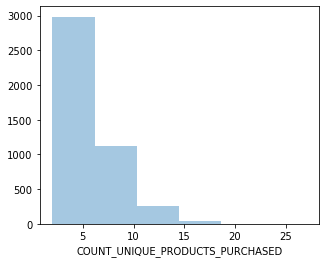

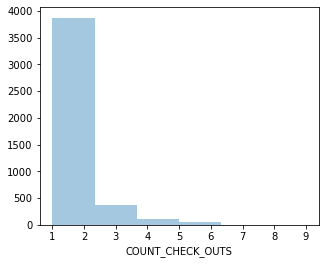

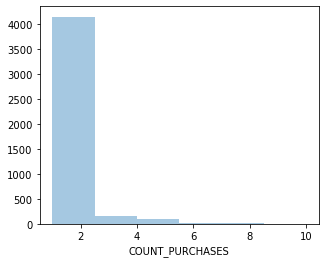

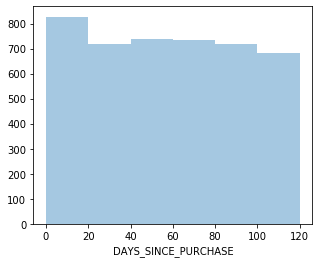

In [52]:
for column in Data_numerical.columns[0:]:
    plt.figure(figsize=(5, 4))
    plt.ticklabel_format(style='plain', axis='y')
    sns.distplot(Data_numerical[column], color = A, kde=False, bins=6, hist_kws={'alpha': 0.4});

<a id="q15"></a>

#### Categorical data

Use rules from a business standpoint to group categories of a categorical variable to get meaningful visualizations.
<br>
There can be thousands of unique values contained in a column, which can render a cluttered plot making it very difficult to draw insights. So, here we are using the top 10 categories to plot distributions.

In [53]:
Data_categorical = Data.select_dtypes(include='object')
Data_categorical.drop(['ID'], axis = 1, inplace = True, errors = 'ignore')

In [54]:
for column in Data_categorical.columns[0:]:
    if (len(Data_categorical[column].value_counts())>10):
        plt.figure(figsize=(12, 8))
        sns.countplot(x=column, data = Data_categorical, order = Data_categorical[column].value_counts().iloc[:10].index, palette="Set2");
    else:
        plt.figure(figsize=(12, 8))
        sns.countplot(x=column, data = Data_categorical, palette="Set2");

##### <font color='blue'>**We now understand the values contained in each of the columns of aggregated data and their distributions!**</font>

# Remove columns that have a single distinct value

Column that have only one value will not add any information to the analysis, hence can be eliminated

In [55]:
for col in Data.columns:
    if len(Data[col].unique()) == 1:
        if col == 'GOAL':
            print(Fore.RED + '\033[1m' + 'WARNING : TARGET HAS A SINGLE UNIQUE VALUE, ANY BIVARIATE ANALYSIS (NEXT STEP IN THIS NOTEBOOK) OR PREDICTION WILL BE MEANINGLESS' + Fore.RESET + '\x1b[21m')
        elif col == 'ID':
            print(Fore.RED + '\033[1m' + 'WARNING : THERE IS ONLY ONE PROFILE IN THE DATA, ANY BIVARIATE ANALYSIS (NEXT STEP IN THIS NOTEBOOK) OR PREDICTION WILL BE MEANINGLESS' + Fore.RESET + '\x1b[21m')
        else:
            print('Dropped column :',col)
            Data.drop(col,inplace=True,axis=1)

#### Check remaining columns

In [56]:
Data.columns

Index(['ID', 'COUNT_UNIQUE_PRODUCTS_PURCHASED', 'COUNT_CHECK_OUTS', 'COUNT_PURCHASES', 'COUNT_INSTANCE_PRODUCTADDS', 'DAYS_SINCE_VISIT', 'DAYS_SINCE_PURCHASE', 'AVG_GAP_BETWEEN_ORDERS_DAYS', 'GOAL'], dtype='object')

<a id="q16"></a>

# Correct for missing value (Some sample approaches)

Even though in the above data we have missing values for only one column, the below code corrects missing values for all data types:
<br>
Numerical data types: impute 0, or max where applicable
<br>
Categorical data types: impute modal value

In [57]:
#### Select only numerical data
Data_numerical = Data.select_dtypes(include=['float64', 'int64'])

#### For columns that contain days we impute max days of history for null values, for rest all we impute 0

# Imputing days with max days of history
Days_cols = [col for col in Data_numerical.columns if 'DAYS_' in col]
d1 = datetime.strptime(analysis_period_day_start, "%Y-%m-%d")
d2 = datetime.strptime(analysis_period_day_end, "%Y-%m-%d")
A = abs((d2 - d1).days)

for column in Days_cols:
    Data[column].fillna(A, inplace=True)

# Imputing 0
Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
Missing_numerical = Data_numerical.columns[Data_numerical.isnull().any()].tolist()

for column in Missing_numerical:
    Data[column].fillna(0, inplace=True)

In [58]:
#### Correct for missing values in categorical columns (Replace with mode)
Data_categorical = Data.select_dtypes(include='object')
Missing_cat = Data_categorical.columns[Data_categorical.isnull().any()].tolist() 
for column in Missing_cat:
    Data[column].fillna(Data[column].mode()[0], inplace=True)

##### <font color='blue'>**We now have clean data to work with!**</font>

<a id="q17"></a>

# Bivariate Analysis

In this section we study understand relationships across features and the target variable. Since different plots cater to categorical and numerical data types, we will do this analysis separately for the two data types.
<br>
Read more on bivariate analysis : https://www.statisticshowto.datasciencecentral.com/bivariate-analysis/
<br>
Some common charts for bivariate analysis:
<br>
**Correlation** : Correlation coefficient is the measure of strength of relationship between two features. Correlation has values between -1 and 1, where:
<br>
1 indicates a strong positive relationship.
<br>
-1 indicates a strong negative relationship.
<br>
A result of zero indicates no relationship at all.
<br>
**Pairplot** : Pair Plots are a really simple way to visualize relationships between each variable. It produces a matrix of relationships between each variable in the data with the goal for an instant examination of our data.
**Heatmap** : This is the correlation coefficient for all variables in the dataset. 
<br>
**Boxplots** : Boxplots are a standardized way of displaying data distribution based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).
<br>
**Countplot** : A countplot is like a histogram or a bar graph for some categorical features. It simply shows the number of occurrences of an item based on a certain type of category.
<br>
To understand relationship between 'goal' variable and the predictors/features we use charts based on datatypes.
<br>
For **numerical features** we use **boxplot** if the **'goal' variable is categorical**, **pairplot** and **heatmap** if the **'goal' variable is numerical**.
<br>
For **categorical features** we use **countplot** if the **'goal' variable is categorical**, **boxplot** if the **'goal' variable is numerical**.

#### Numerical predictors

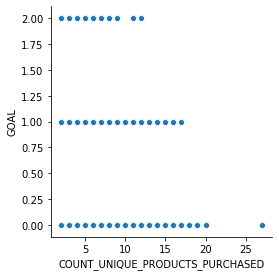

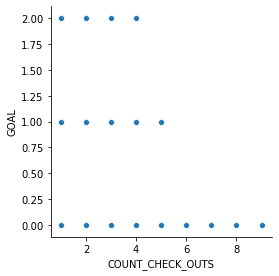

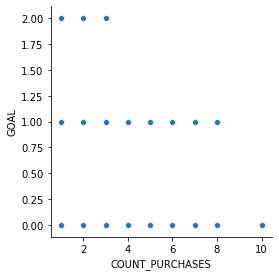

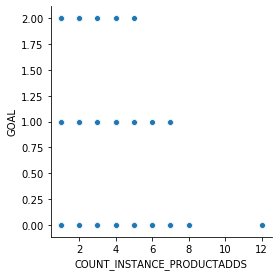

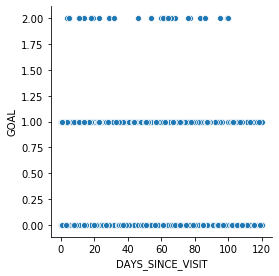

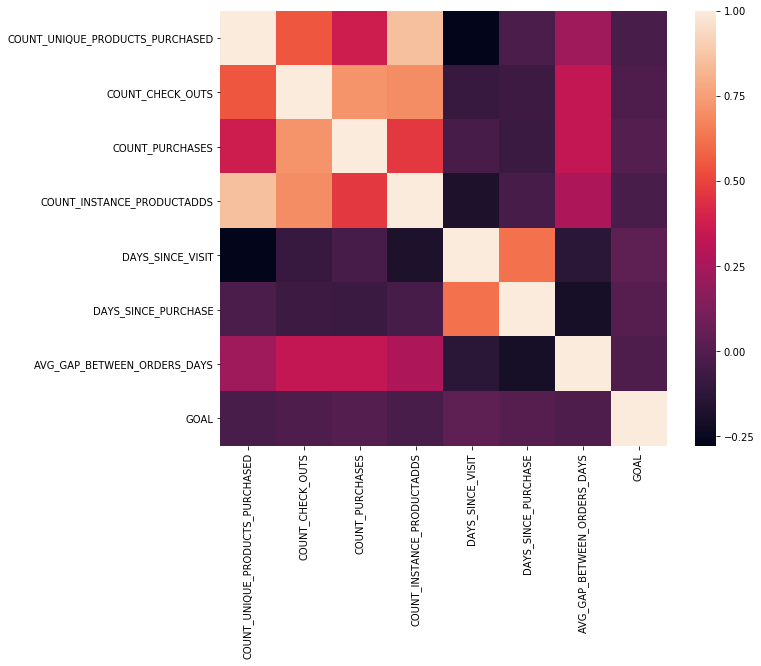

In [63]:
if len(Data) == 1:
    print(Fore.RED + '\033[1m' + 'THERE IS ONLY ONE PROFILE IN THE DATA, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE AT LEAST ONE MORE PROFILE TO DO BIVARIATE ANALYSIS')
elif len(Data['GOAL'].unique()) == 1:
    print(Fore.RED + '\033[1m' + 'TARGET HAS A SINGLE UNIQUE VALUE, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE PROFILES WITH ATLEAST ONE DIFFERENT VALUE OF TARGET TO DO BIVARIATE ANALYSIS')
else:
    if (goal_column_type == "categorical"):
        TARGET_categorical = pd.DataFrame(np.where(GOAL>=threshold,"1","0"))
        TARGET_categorical.rename(columns={TARGET_categorical.columns[0]: "TARGET_categorical" }, inplace = True)
        Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
        Data_numerical.drop(['GOAL'],inplace=True,axis=1)
        Data_numerical = pd.concat([Data_numerical, TARGET_categorical.astype(int)], axis = 1)
        ncols_for_charts = len(Data_numerical.columns)-1
        nrows_for_charts = math.ceil(ncols_for_charts/4)
        fig, axes = plt.subplots(nrows=nrows_for_charts, ncols=4, figsize=(18, 15))
        for idx, feat in enumerate(Data_numerical.columns[:-1]):
            ax = axes[int(idx // 4), idx % 4]
            sns.boxplot(x='TARGET_categorical', y=feat, data=Data_numerical, ax=ax)
            ax.set_xlabel('')
            ax.set_ylabel(feat)
            fig.tight_layout();
    else:
        Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
        TARGET = pd.DataFrame(Data_numerical.GOAL)
        Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
        Data_numerical.drop(['GOAL'],inplace=True,axis=1)
        Data_numerical = pd.concat([Data_numerical, TARGET.astype(int)], axis = 1)
        for i in Data_numerical.columns[:-1]:
            sns.pairplot(x_vars=i, y_vars=['GOAL'], data=Data_numerical, height = 4)
        f, ax = plt.subplots(figsize = (10,8))
        corr = Data_numerical.corr()
        sns.heatmap(corr, square=False)

#### Categorical predictors

Plot and view the frequency plots for top 10 categories of each categorical variable

In [65]:
if len(Data) == 1:
    print(Fore.RED + '\033[1m' + 'THERE IS ONLY ONE PROFILE IN THE DATA, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE AT LEAST ONE MORE PROFILE TO DO BIVARIATE ANALYSIS')
elif len(Data['GOAL'].unique()) == 1:
    print(Fore.RED + '\033[1m' + 'TARGET HAS A SINGLE UNIQUE VALUE, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE PROFILES WITH ATLEAST ONE DIFFERENT VALUE OF TARGET TO DO BIVARIATE ANALYSIS')
else:
    if (goal_column_type == "categorical"):
        TARGET_categorical = pd.DataFrame(np.where(GOAL>=threshold,"1","0"))
        TARGET_categorical.rename(columns={TARGET_categorical.columns[0]: "TARGET_categorical" }, inplace = True)
        Data_categorical = Data.select_dtypes(include='object')
        Data_categorical.drop(["ID"], axis =1, inplace = True)
        Cat_columns = Data_categorical
        Data_categorical = pd.concat([TARGET_categorical,Data_categorical], axis =1)
        for column in Cat_columns.columns:
            A = Data_categorical[column].value_counts().iloc[:10].index
            Data_categorical1 = Data_categorical[Data_categorical[column].isin(A)]
            plt.figure(figsize=(12, 8))
            sns.countplot(x="TARGET_categorical",hue=column, data = Data_categorical1, palette = 'Blues')
            plt.xlabel("GOAL")
            plt.ylabel("COUNT")
            plt.show();
    else:
        Data_categorical = Data.select_dtypes(include='object')
        Data_categorical.drop(["ID"], axis =1, inplace = True)
        Target = Data.GOAL
        Data_categorical = pd.concat([Data_categorical,Target], axis =1)
        for column in Data_categorical.columns[:-1]:
            A = Data_categorical[column].value_counts().iloc[:10].index
            Data_categorical1 = Data_categorical[Data_categorical[column].isin(A)]
            sns.catplot(x=column, y="GOAL", kind = "boxen", data =Data_categorical1, height=5, aspect=13/5);

##### <font color='Blue'>**We now understand the relationship between features or the predictors and the goal!**</font>

<a id="q18"></a>

# Important numerical features

We will find the important numerical features using correlation analysis. Below are the top ten features that can be used to predict the 'goal' feature.

In [67]:
if len(Data) == 1:
    print(Fore.RED + '\033[1m' + 'THERE IS ONLY ONE PROFILE IN THE DATA, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE AT LEAST ONE MORE PROFILE TO FIND IMPORTANT VARIABLES')
elif len(Data['GOAL'].unique()) == 1:
    print(Fore.RED + '\033[1m' + 'TARGET HAS A SINGLE UNIQUE VALUE, BIVARIATE ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE PROFILES WITH ATLEAST ONE DIFFERENT VALUE OF TARGET TO FIND IMPORTANT VARIABLES')
else:
    Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
    Correlation = pd.DataFrame(Data_numerical.drop("GOAL", axis=1).apply(lambda x: x.corr(Data_numerical.GOAL)))
    Correlation['Corr_abs'] = abs(Correlation)
    Correlation = Correlation.sort_values(by = 'Corr_abs', ascending = False)
    Imp_features = pd.DataFrame(Correlation.index[0:10])
    Imp_features.rename(columns={0:'Important Feature'}, inplace=True)
    print(Imp_features)

                 Important Feature
0  DAYS_SINCE_VISIT               
1  COUNT_UNIQUE_PRODUCTS_PURCHASED
2  COUNT_INSTANCE_PRODUCTADDS     
3  COUNT_CHECK_OUTS               
4  AVG_GAP_BETWEEN_ORDERS_DAYS    
5  DAYS_SINCE_PURCHASE            
6  COUNT_PURCHASES                


##### <font color='blue'>**We now have a list of important features to start building your model!**</font>

<a id="q19"></a>

# Insight : Recency value for for target event

In [74]:
# Proxy for monetary value is TOTAL_ORDER_REVENUE and proxy for frequency is NUMBER_VISITS
if len(Data) == 1:
    print(Fore.RED + '\033[1m' + 'THERE IS ONLY ONE PROFILE IN THE DATA, INSIGHTS ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE AT LEAST ONE MORE PROFILE TO FIND IMPORTANT VARIABLES')
elif len(Data['TARGET'].unique()) == 1:
    print(Fore.RED + '\033[1m' + 'TARGET HAS A SINGLE UNIQUE VALUE, INSIGHTS ANALYSIS IS NOT APPLICABLE, PLEASE INCLUDE PROFILES WITH ATLEAST ONE DIFFERENT VALUE OF TARGET TO FIND IMPORTANT VARIABLES')
else:
    sns.lmplot("DAYS_SINCE_VISIT", "COUNT_UNIQUE_PRODUCTS_PURCHASED", Data, hue="TARGET", fit_reg=False);

<a id="q20"></a>

# Optional Steps (Data cleaning)

Correcting outliers requires us to have business/industry understanding, sometimes it is not acceptable to drop an observation just because it is an outlier. They can be legitimate observations and are sometimes the most interesting ones. 

Read more : https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

The below code caps and floors data points that are outliers.

# Correct outliers in numerical columns. For this we use the interquartile range.

Read more : https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244

In [73]:
TARGET = Data.TARGET

Data_numerical = Data.select_dtypes(include=['float64', 'int64'])
Data_numerical.drop(['TARGET'],axis = 1,inplace = True)

for i in range(0,len(Data_numerical.columns)):
    Q1 = Data_numerical.iloc[:,i].quantile(0.25)
    Q3 = Data_numerical.iloc[:,i].quantile(0.75)
    IQR = Q3 - Q1
    Data_numerical.iloc[:,i] = np.where(Data_numerical.iloc[:,i]<(Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR), np.where(Data_numerical.iloc[:,i]>(Q3 + 1.5 * IQR),
                                                                                                     (Q3 + 1.5 * IQR),Data_numerical.iloc[:,i]))
Data_categorical = Data.select_dtypes(include='object')
Data = pd.concat([Data_categorical, Data_numerical, TARGET], axis = 1)

##### <font color='blue'>**We now have clean data and an understanding of the important columns for our model building exercise!**</font>